# K-NearestNeighbour Sex Classification

## Initial Setup

### Imports

In [1]:
import numpy as np
import networkx as nx
import scipy as sp
import matplotlib.pyplot as plt
import os
import csv

from collections import OrderedDict
from sklearn import cross_validation
from sklearn.preprocessing import normalize
from sklearn.cross_validation import LeaveOneOut, LeaveOneLabelOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from scipy.linalg import svd

%matplotlib inline

font = {'weight' : 'bold',
        'size'   : 18}

import matplotlib
matplotlib.rc('font', **font)

np.random.seed(12345678)  # for reproducibility, set random seed

### Getting File Lists

In [2]:
# Initializing dataset names
dataset_names = list(('KKI2009', 'MRN114', 'SWU4', 'BNU1', 'BNU3'))
# dataset_names = list(('KKI2009', 'MRN114', 'BNU1', 'BNU3'))

basepath = '/Users/gkiar/code/classes/upward-spiral/grelliam/data/'
atlas = 'desikan'
dir_names = [basepath + '/' + atlas + '/' + d for d in dataset_names]

#  Crawls directories and creates a dictionary entry of file names for each
#  dataset which we plan to process.
fs = OrderedDict()
for idx, dd in enumerate(dataset_names):
    fs[dd] = [root + "/" + fl for root, dirs, files in os.walk(dir_names[idx])
              for fl in files if fl.endswith(".graphml")]

ps = {os.path.splitext(os.path.basename(fl))[0] : root + "/" + fl
      for root, dirs, files in os.walk(basepath+'phenotypes')
      for fl in files if fl.endswith(".csv") }

print "Datasets: " + ", ".join([fkey + ' (' + str(len(fs[fkey])) + ')'
                                for fkey in fs])
print "Total Subjects: %d" % (sum([len(fs[key]) for key in fs]))


Datasets: KKI2009 (42), MRN114 (114), SWU4 (454), BNU1 (81), BNU3 (46)
Total Subjects: 737


### Declaring Graph Read Helper Functions

In [3]:
def loadGraphs(filenames, verb=False):
    """
    Given a list of files, returns a dictionary of graphs

    Required parameters:
        filenames:
            - List of filenames for graphs
    Optional parameters:
        verb:
            - Toggles verbose output statements
    """
    #  Initializes empty dictionary
    gstruct = OrderedDict()
    for idx, files in enumerate(filenames):
        if verb:
            print "Loading: " + files
        #  Adds graphs to dictionary with key being filename
        fname = os.path.basename(files)
        gstruct[fname] = nx.read_graphml(files)
    return gstruct

def constructGraphDict(names, fs, verb=False):
    """
    Given a set of files and a directory to put things, loads graphs.

    Required parameters:
        names:
            - List of names of the datasets
        fs:
            - Dictionary of lists of files in each dataset
    Optional parameters:
        verb:
            - Toggles verbose output statements
    """
    #  Loads graphs into memory for all datasets
    graphs = OrderedDict()
    for idx, name in enumerate(names):
        if verb:
            print "Loading Dataset: " + name
        # The key for the dictionary of graphs is the dataset name
        graphs[name] = loadGraphs(fs[name], verb=verb)
    return graphs

### Reading Graphs

In [4]:
graphs = constructGraphDict(dataset_names, fs, verb=False)

### Reading Phenotypes

In [5]:
phenotypes = OrderedDict()
for dataset in dataset_names:
    tmp = csv.reader(open(ps[dataset]))
    pheno = OrderedDict()
    if dataset == 'KKI2009':
        triple = [[t[1].strip(), t[4], int(t[5] == 'M')] for t in tmp][1:]  # female=F->0, male=M->1
    elif dataset == 'MRN114':
        triple = [[t[0].strip(), t[3], int(t[2] == '1')] for t in tmp][1:]  # female=0->0, male=1->1
    else:
        triple = [[t[0].strip(), t[2], int(t[3] == '2')] for t in tmp
                  if t[3] != '#' and t[2] != '#'][1:]  # female=1->0, male=2->1
    
    for idx, trip in enumerate(triple):
        pheno[trip[0]] = trip[1:]
    phenotypes[dataset] = pheno

### Converting Graphs to Vectors and Phenotypes to List

In [6]:
N = nx.number_of_nodes(graphs[graphs.keys()[0]][graphs[graphs.keys()[0]].keys()[0]])
feat = np.empty((0, int(sp.special.binom(N,2))), int)
dats = list(())
ages = np.array(())
sexy = np.array(())
sbjs = list(())


for idx1, dset in enumerate(graphs):
    for idx2, subj in enumerate(graphs[dset]):
        A = nx.adjacency_matrix(graphs[dset][subj]).todense()
        Au = A[np.triu_indices(A.shape[0], 1)]
        feat = np.append(feat, Au, axis=0)
        dats.append(dset)

        try:
            subj_id = str(int(subj.split('_')[1]))
        except:
            subj_id = subj.split('_')[1]

        sbjs.append(subj_id)

        ages = np.append(ages, int(phenotypes[dset][subj_id][0]))
        sexy = np.append(sexy, int(phenotypes[dset][subj_id][1]))
# print feat.shape, ages.shape, sexy.shape
# print sum(sexy == 0), sum(sexy == 1)
# print dats

---------
## Regress Graphs

### KNN LOO Dataset Regression

In [ ]:
knn_age = OrderedDict()
for i in np.arange(20):
    regress = KNeighborsRegressor(n_neighbors=2*(i+1)-1)
#     print "============="
#     print "K nearest Neighbors: %d" % (2*(i+1)-1)
    tmp = np.array(())
    for idx, dset in enumerate(dataset_names):
        ind = np.array([dset == d for d in dats])
        ft_train = feat[ind < 1] # current dataset is test
        ft_test = feat[ind >= 1] # all others are train
        ag_train = ages[ind < 1]
        ag_test = ages[ind >= 1]
        regress.fit(ft_train, ag_train)
        score = regress.score(ft_test, ag_test)
        tmp = np.append(tmp, score)
#         print "~~~~~~~~~~~~"
#         print "Left out dataset: %s" % (dset)
#         print "Train: %d ; Test: %d" % (sx_train.shape[0], sx_test.shape[0])
#         print "Chance: %0.5f (%0.5f)" % (sum(sx_test)/len(sx_test), 1-sum(sx_test)/len(sx_test)) 
#         print "Classification Accuracy: %.5f (%0.5f)" % (score, 1-score)
    knn_age[i] = tmp

In [ ]:
# fig = plt.figure(figsize=(8,6))
# mean = [np.mean(knn_age[i]) for i in knn_age]
# maxx = [max(knn_age[i]) for i in knn_age]
# stder = [np.std(knn_age[i])/np.sqrt(len(dataset_names)) for i in knn_age]
# plt.hold(True)
# plt.plot((np.arange(20)+1)*2-1, maxx, lw=2, color='#f50000', linestyle='--')
# plt.errorbar((np.arange(20)+1)*2-1, mean, stder, lw=2, color='#000000')
# # plt.ylim((0.5, 0.7))
# # plt.yticks((0.5, 0.6, 0.7),(0.5, 0.6, 0.7))
# plt.xticks((0, 20, 40),(0, 20, 40))
# plt.xlabel('Size of Neighbourhood (k)')
# plt.ylabel('Accuracy')
# plt.title('Age Regression Accuracy With \nLOO-Dataset')
# lgd = plt.legend(('Max', 'Mean'), fontsize=16, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.tight_layout(1)
# plt.savefig('../../figs/graphs/desikan/regression/knn_vectorgraph_regress.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
# plt.show()

#### KNN LOO Dataset Regression with PCA

In [ ]:
knn_pca_age = OrderedDict()
dims = 150

for i in np.arange(20):
    regress = KNeighborsRegressor(n_neighbors=2*(i+1)-1)
#     print "============="
#     print "K nearest Neighbors: %d" % (2*(i+1)-1)
    tmp = np.array(())
    for idx, dset in enumerate(dataset_names):
        ind = np.array([dset == d for d in dats])
        ft_train = feat[ind < 1] # current dataset is test
        ft_test = feat[ind >= 1] # all others are train
        ag_train = ages[ind < 1]
        ag_test = ages[ind >= 1]

        # take SVD and rotate data
        u, s, vh = svd(ft_train)
        ft_train_t = np.dot(u,np.diag(s))[:, 0:dims]
        regress.fit(ft_train_t, ag_train)

        ft_test_t = np.dot(ft_test, vh)[:, 0:dims]
        score = regress.score(ft_test_t, ag_test)
        tmp = np.append(tmp, score)

#         print "~~~~~~~~~~~~"
#         print "Left out dataset: %s" % (dset)
#         print "Train: %d ; Test: %d" % (sx_train.shape[0], sx_test.shape[0])
#         print "Chance: %0.5f (%0.5f)" % (sum(sx_test)/len(sx_test), 1-sum(sx_test)/len(sx_test)) 
#         print "Classification Accuracy: %.5f (%0.5f)" % (score, 1-score)

    knn_pca_age[i] = tmp

In [ ]:
# fig = plt.figure(figsize=(8,6))
# mean = [np.mean(knn_pca_age[i]) for i in knn_pca_age]
# maxx = [max(knn_pca_age[i]) for i in knn_pca_age]
# stder = [np.std(knn_pca_age[i])/np.sqrt(len(dataset_names)) for i in knn_pca_age]
# plt.hold(True)
# plt.plot((np.arange(20)+1)*2-1, maxx, lw=2, color='#f50000', linestyle='--')
# plt.errorbar((np.arange(20)+1)*2-1, mean, stder, lw=2, color='#000000')
# # plt.ylim((0.5, 0.7))
# # plt.yticks((0.5, 0.6, 0.7),(0.5, 0.6, 0.7))
# plt.xticks((0, 20, 40),(0, 20, 40))
# plt.xlabel('Size of Neighbourhood (k)')
# plt.ylabel('Accuracy')
# plt.title('Age Regression Accuracy With \nLOO-Dataset And PCA')
# lgd = plt.legend(('Max', 'Mean'), fontsize=16, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.tight_layout(1)
# plt.savefig('../../figs/graphs/desikan/regression/knn_pca_regress.png',bbox_extra_artists=(lgd,), bbox_inches='tight')
# plt.show()

---------

---------

## Classify Graphs

### KNN LOO Scan Cross Validation

In [7]:
mean_loo_scan = np.array(())
std_loo_scan = np.array(())
neighbourhoods = (np.arange(19)+2)*2-1
print "Neighbourhoods complete:",
for i in neighbourhoods:
    classif = KNeighborsClassifier(i)
    loo = LeaveOneOut(len(sexy))
    score = cross_validation.cross_val_score(classif, feat, sexy, cv=loo)
    mean_loo_scan = np.append(mean_loo_scan, score.mean())
    std_loo_scan = np.append(std_loo_scan, score.std())
    print i,
print "."
#     print("Accuracy for community size %d: %0.2f (+/- %0.2f)" % (i, score.mean(), score.std()))

Neighbourhoods complete: 3 5 7 9 11 13 15 17 19 21 23 25 27 29 31 33 35 37 39 .


### KNN LOO Subject Cross Validation

In [8]:
mean_loo_subj = np.array(())
std_loo_subj = np.array(())
print "Neighbourhoods complete:",
for i in neighbourhoods:
    classif = KNeighborsClassifier(i)
    lolo = LeaveOneLabelOut(sbjs)
    score = cross_validation.cross_val_score(classif, feat, sexy, cv=lolo)
    mean_loo_subj = np.append(mean_loo_subj, score.mean())
    std_loo_subj = np.append(std_loo_subj, score.std())
    print i,
print "."
#     print("Accuracy for community size %d: %0.2f (+/- %0.2f)" % (i, score.mean(), score.std()))

Neighbourhoods complete: 3 5 7 9 11 13 15 17 19 21 23 25 27 29 31 33 35 37 39 .


### KNN LOO Dataset

In [9]:
knn = OrderedDict()
for i in neighbourhoods:
    classif = KNeighborsClassifier(i)
    tmp = np.array(())
    for idx, dset in enumerate(dataset_names):
        ind = np.array([dset == d for d in dats])
        ft_train = feat[ind < 1] # current dataset is test
        ft_test = feat[ind >= 1] # all others are train
        sx_train = sexy[ind < 1]
        sx_test = sexy[ind >= 1]
        classif.fit(ft_train, sx_train)
        score = classif.score(ft_test, sx_test)
        tmp = np.append(tmp, score)
#         print "Classification Accuracy: %.5f (%0.5f)" % (score, 1-score)
    knn[i] = tmp

knn_loo_dsetx = np.array(())
knn_loo_dsety = np.array(())
for i in neighbourhoods:
    knn_loo_dsetx = np.append(knn_loo_dsetx, np.repeat(i, len(dataset_names))+1*np.random.rand(len(dataset_names)))
    knn_loo_dsety = np.append(knn_loo_dsety, knn[i])

### KNN LOO Dataset with PCA 

In [10]:
knn_pca = OrderedDict()
dims = 150

for i in neighbourhoods:
    classif = KNeighborsClassifier(i)
    tmp = np.array(())
    for idx, dset in enumerate(dataset_names):
        ind = np.array([dset == d for d in dats])
        ft_train = feat[ind < 1] # current dataset is test
        ft_test = feat[ind >= 1] # all others are train
        sx_train = sexy[ind < 1]
        sx_test = sexy[ind >= 1]

        # take SVD and rotate data
        u, s, vh = svd(ft_train)
        ft_train_t = np.dot(u,np.diag(s))[:, 0:dims]
        classif.fit(ft_train_t, sx_train)

        ft_test_t = np.dot(ft_test, vh)[:, 0:dims]
        score = classif.score(ft_test_t, sx_test)
        tmp = np.append(tmp, score)

#         print "~~~~~~~~~~~~"
#         print "Left out dataset: %s" % (dset)
#         print "Train: %d ; Test: %d" % (sx_train.shape[0], sx_test.shape[0])
#         print "Chance: %0.5f (%0.5f)" % (sum(sx_test)/len(sx_test), 1-sum(sx_test)/len(sx_test)) 
#         print "Classification Accuracy: %.5f (%0.5f)" % (score, 1-score)
    knn_pca[i] = tmp

knn_loo_dset_pcax = np.array(())
knn_loo_dset_pcay = np.array(())
for i in neighbourhoods:
    knn_loo_dset_pcax = np.append(knn_loo_dset_pcax, np.repeat(i, len(dataset_names))+1*np.random.rand(len(dataset_names)))
    knn_loo_dset_pcay = np.append(knn_loo_dset_pcay, knn[i])

### KNN LOO Dataset after subtracting cohort mean

In [11]:
feat_cm = np.copy(feat)
# print feat[600]
for idx, dset in enumerate(dataset_names):
    ind = np.array([dset == d for d in dats])
    curr = feat_cm[ind < 1] # current dataset is test
    mean = np.mean(curr, axis=0)
    updated = curr - mean
    feat_cm[ind < 1] = updated
# print feat_cm[600]

In [12]:
knn = OrderedDict()
for i in neighbourhoods:
    classif = KNeighborsClassifier(n_neighbors=2*(i+1)-1)
    tmp = np.array(())
    for idx, dset in enumerate(dataset_names):
        ind = np.array([dset == d for d in dats])
        ft_train = feat_cm[ind < 1] # current dataset is test
        ft_test = feat_cm[ind >= 1] # all others are train
        sx_train = sexy[ind < 1]
        sx_test = sexy[ind >= 1]
        classif.fit(ft_train, sx_train)
        score = classif.score(ft_test, sx_test)
        tmp = np.append(tmp, score)
#         print "Classification Accuracy: %.5f (%0.5f)" % (score, 1-score)
    knn[i] = tmp

knn_loo_dset_cmx = np.array(())
knn_loo_dset_cmy = np.array(())
for i in neighbourhoods:
    knn_loo_dset_cmx = np.append(knn_loo_dset_cmx, np.repeat(i, len(dataset_names))+1*np.random.rand(len(dataset_names)))
    knn_loo_dset_cmy = np.append(knn_loo_dset_cmy, knn[i])

### KNN LOO Dataset after subtracting population and then cohort means

In [13]:
pm = np.mean(feat, axis=0)
feat_pm = feat - pm

feat_pm_cm = np.copy(feat_pm)
# print feat_pm[600]
for idx, dset in enumerate(dataset_names):
    ind = np.array([dset == d for d in dats])
    curr = feat_pm_cm[ind < 1] # current dataset is test
    mean = np.mean(curr, axis=0)
    updated = curr - mean
    feat_pm_cm[ind < 1] = updated
# print feat_pm_cm[600]

In [14]:
knn = OrderedDict()
for i in neighbourhoods:
    classif = KNeighborsClassifier(n_neighbors=2*(i+1)-1)
    tmp = np.array(())
    for idx, dset in enumerate(dataset_names):
        ind = np.array([dset == d for d in dats])
        ft_train = feat_pm_cm[ind < 1] # current dataset is test
        ft_test = feat_pm_cm[ind >= 1] # all others are train
        sx_train = sexy[ind < 1]
        sx_test = sexy[ind >= 1]
        classif.fit(ft_train, sx_train)
        score = classif.score(ft_test, sx_test)
        tmp = np.append(tmp, score)
#         print "Classification Accuracy: %.5f (%0.5f)" % (score, 1-score)
    knn[i] = tmp

knn_loo_dset_pmcmx = np.array(())
knn_loo_dset_pmcmy = np.array(())
for i in neighbourhoods:
    knn_loo_dset_pmcmx = np.append(knn_loo_dset_pmcmx, np.repeat(i, len(dataset_names))+1*np.random.rand(len(dataset_names)))
    knn_loo_dset_pmcmy = np.append(knn_loo_dset_pmcmy, knn[i])

### KNN LOO Dataset after normalizing data

In [15]:
feat_un = normalize(feat)

In [17]:
knn = OrderedDict()
for i in neighbourhoods:
    classif = KNeighborsClassifier(n_neighbors=2*(i+1)-1)
    tmp = np.array(())
    for idx, dset in enumerate(dataset_names):
        ind = np.array([dset == d for d in dats])
        ft_train = feat_un[ind < 1] # current dataset is test
        ft_test = feat_un[ind >= 1] # all others are train
        sx_train = sexy[ind < 1]
        sx_test = sexy[ind >= 1]
        classif.fit(ft_train, sx_train)
        score = classif.score(ft_test, sx_test)
        tmp = np.append(tmp, score)
#         print "Classification Accuracy: %.5f" % (score)
    knn[i] = tmp

knn_loo_dset_unx = np.array(())
knn_loo_dset_uny = np.array(())
for i in neighbourhoods:
    knn_loo_dset_unx = np.append(knn_loo_dset_unx, np.repeat(i, len(dataset_names))+1*np.random.rand(len(dataset_names)))
    knn_loo_dset_uny = np.append(knn_loo_dset_uny, knn[i])

---------

---------

## Save the things

In [18]:
result_file = '../../data/graphs/classification_results.npz'
np.savez(result_file,
         neighbourhoods=neighbourhoods,
         mean_loo_scan=mean_loo_scan, std_loo_scan=std_loo_scan,
         mean_loo_subj=mean_loo_subj, std_loo_subj=std_loo_subj,
         knn_loo_dsetx=knn_loo_dsetx, knn_loo_dsety=knn_loo_dsety,
         knn_loo_dset_cmx=knn_loo_dset_cmx, knn_loo_dset_cmy=knn_loo_dset_cmy,
         knn_loo_dset_pmcmx=knn_loo_dset_pmcmx, knn_loo_dset_pmcmy=knn_loo_dset_pmcmy,
         knn_loo_dset_unx=knn_loo_dset_unx, knn_loo_dset_uny=knn_loo_dset_uny,
         knn_loo_dset_pcax=knn_loo_dset_unx, knn_loo_dset_pcay=knn_loo_dset_uny)

feature_file = '../../data/graphs/classified_vectors.npz'
np.savez(feature_file,
         ages=ages,
         sexy=sexy,
         sbjs=sbjs,
         feat=feat,
         feat_cm=feat_cm,
         feat_pm_cm=feat_pm_cm,
         feat_un=feat_un)

---------

---------

## Load the things

In [87]:
dat = np.load(feature_file)
dat.files

['sbjs', 'ages', 'feat_pm_cm', 'feat_cm', 'sexy', 'feat']

---------

---------

## Plot the things

### Plot as scatter

In [ ]:
fig = plt.figure(figsize=(1.2*8,8))
plt.errorbar(neighbourhoods, mean_loo_scan, std_loo_scan/np.sqrt(len(sexy)), lw=3, color='#00ee00')
plt.errorbar(neighbourhoods, mean_loo_subj, std_loo_subj/np.sqrt(len(sexy)), lw=3, color='#ee0000')
plt.hold(True)
plt.axhline(sum(sexy)/len(sexy), linestyle='--', lw=5, alpha=0.5, color="#0000ee")
plt.scatter(knn_loo_dsetx, knn_loo_dsety, lw=3, color='#000000', alpha=0.75, linestyle='--')
plt.scatter(knn_loo_dset_cmx, knn_loo_dset_cmy, lw=3, color='#ee00ee', alpha=0.75, linestyle='--')
plt.scatter(knn_loo_dset_pmcmx, knn_loo_dset_pmcmy, lw=3, color='#eeee00', alpha=0.75, linestyle='--')

# plt.ylim((0.5, 0.7))
# plt.yticks((0.5, 0.6, 0.7),(0.5, 0.6, 0.7))
# plt.xticks((0, 20, 40),(0, 20, 40))
plt.xlim([2, 40])
plt.ylim([0.35, 0.8])
plt.xlabel('Size of Neighbourhood (k)')
plt.ylabel('Accuracy')
plt.title('KNN Sex Classification With Multiple Datasets')
lgd = plt.legend(('Chance', 'LOO-Dataset', 'LOO-Dataset - CM', 'LOO-Dataset - PM - CM',
            'LOO-Scan', 'LOO-Subj'), fontsize=16, bbox_to_anchor = (1.5, 1))
plt.tight_layout(1)
plt.savefig('../../figs/graphs/desikan/classification/knn_vectorgraph_class.png',
            bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

### Plotting as errorbars

In [20]:
knn_loo_dsetx = np.floor(knn_loo_dsetx)
knn_loo_dset_pcax = np.floor(knn_loo_dset_pcax)
knn_loo_dset_cmx = np.floor(knn_loo_dset_cmx)
knn_loo_dset_pmcmx= np.floor(knn_loo_dset_pmcmx)
knn_loo_dset_unx = np.floor(knn_loo_dset_unx)

mean_loo_dset = np.array(())
std_loo_dset = np.array(())

mean_loo_dset_pca = np.array(())
std_loo_dset_pca = np.array(())

mean_loo_dset_cm = np.array(())
std_loo_dset_cm = np.array(())

mean_loo_dset_pmcm = np.array(())
std_loo_dset_pmcm = np.array(())

mean_loo_dset_un = np.array(())
std_loo_dset_un = np.array(())

for idx in neighbourhoods:
    tmp = knn_loo_dsety[knn_loo_dsetx == idx]
#     print len(tmp)
    mean_loo_dset = np.append(mean_loo_dset, np.mean(tmp))
    std_loo_dset = np.append(std_loo_dset, np.std(tmp))

    tmp_pca = knn_loo_dset_pcay[knn_loo_dset_pcax == idx]
#     print len(tmp_pca)
    mean_loo_dset_pca = np.append(mean_loo_dset_pca, np.mean(tmp_pca))
    std_loo_dset_pca = np.append(std_loo_dset_pca, np.std(tmp_pca))
    
    tmp_cm = knn_loo_dset_cmy[knn_loo_dset_cmx == idx]
#     print len(tmp_cm)
    mean_loo_dset_cm = np.append(mean_loo_dset_cm, np.mean(tmp_cm))
    std_loo_dset_cm = np.append(std_loo_dset_cm, np.std(tmp_cm))

    tmp_pmcm = knn_loo_dset_pmcmy[knn_loo_dset_pmcmx == idx]
#     print len(tmp_pmcm)
    mean_loo_dset_pmcm = np.append(mean_loo_dset_pmcm, np.mean(tmp_pmcm))
    std_loo_dset_pmcm = np.append(std_loo_dset_pmcm, np.std(tmp_pmcm))
    
    tmp_pmcm = knn_loo_dset_uny[knn_loo_dset_unx == idx]
#     print len(tmp_pmcm)
    mean_loo_dset_un = np.append(mean_loo_dset_un, np.mean(tmp_pmcm))
    std_loo_dset_un = np.append(std_loo_dset_un, np.std(tmp_pmcm))
    
print len(std_loo_dset_cm), len(std_loo_dset_pca), len(mean_loo_dset_cm),
print len(std_loo_dset_pmcm), len(mean_loo_dset_pmcm), len(mean_loo_dset_un)

19 19 19 19 19 19


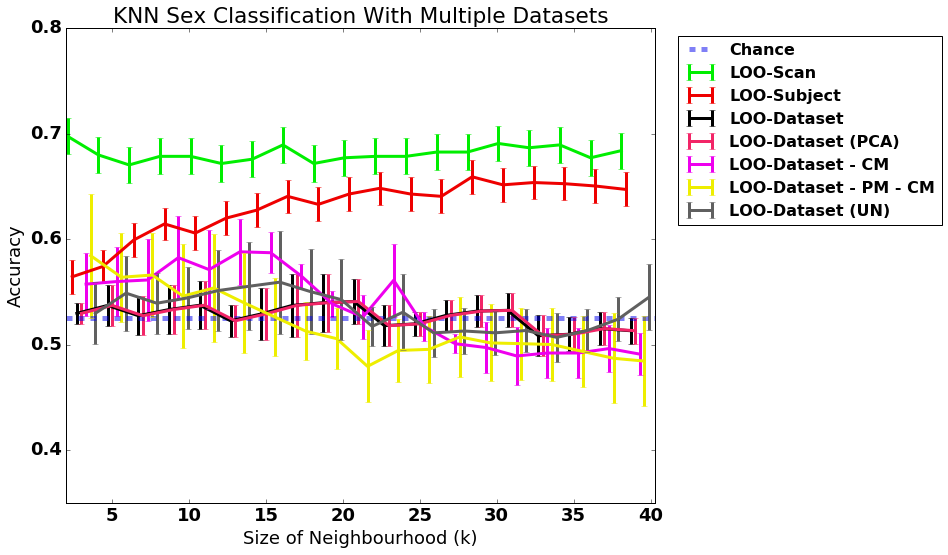

In [24]:
fig = plt.figure(figsize=(1.2*8,8))
plt.errorbar(neighbourhoods-0.9, mean_loo_scan, std_loo_scan/np.sqrt(len(sexy)), lw=3, color='#00ee00')
plt.errorbar(neighbourhoods-0.6, mean_loo_subj, std_loo_subj/np.sqrt(len(sexy)), lw=3, color='#ee0000')
plt.hold(True)
plt.axhline(sum(sexy)/len(sexy), linestyle='--', lw=5, alpha=0.5, color="#0000ee")
plt.errorbar(neighbourhoods-0.3, mean_loo_dset, std_loo_dset/np.sqrt(len(dataset*1)), lw=3, color='#000000')
plt.errorbar(neighbourhoods, mean_loo_dset_pca, std_loo_dset_pca/np.sqrt(len(dataset*1)), lw=3, color='#f22567')
plt.errorbar(neighbourhoods+0.3, mean_loo_dset_cm, std_loo_dset_cm/np.sqrt(len(dataset*1)), lw=3, color='#ee00ee')
plt.errorbar(neighbourhoods+0.6, mean_loo_dset_pmcm, std_loo_dset_pmcm/np.sqrt(len(dataset*1)), lw=3, color='#eeee00')
plt.errorbar(neighbourhoods+0.9, mean_loo_dset_un, std_loo_dset_un/np.sqrt(len(dataset*1)), lw=3, color='#606060')

# plt.ylim((0.5, 0.7))
# plt.yticks((0.5, 0.6, 0.7),(0.5, 0.6, 0.7))
# plt.xticks((0, 20, 40),(0, 20, 40))
plt.xlim([2, 40.3])
plt.ylim([0.35, 0.8])
plt.xlabel('Size of Neighbourhood (k)')
plt.ylabel('Accuracy')
plt.title('KNN Sex Classification With Multiple Datasets')
lgd = plt.legend(('Chance', 'LOO-Scan', 'LOO-Subject', 'LOO-Dataset', 'LOO-Dataset (PCA)',
                  'LOO-Dataset - CM', 'LOO-Dataset - PM - CM', 'LOO-Dataset (UN)'),
                 fontsize=16, bbox_to_anchor = (1.5, 1))
plt.tight_layout(1)
plt.savefig('../../figs/graphs/desikan/classification/knn_vectorgraph_class_errorbars.png',
            bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

### Next steps
1. normalize graphs such that each matrix is unit norm
2. semipar (i.e. eigen decomp to d dimensions then procrustese distance). distance metric is the procrustese if I already embed. Zhu and Ghandzi for finding elbows, do median of zg2 for d.